In [11]:
from library.objective_function import *
from library.optimiser import *
from library.post_analysis import *
from library.experiments import *
%matplotlib inline
SEED = 1231

In [12]:
def do_multiple_exps(obj, opt, zoneParas):
    np.random.seed(SEED)
    
    # init multiple experiments
    mexps = multiple_experiment()

    # init one experiment
    exp = single_experiment()
    
    # One experiment: setup objective function and optimiser
    exp.set_objective(obj)
    exp.set_optimizer(opt)

    # Multiple experiment: setup one expreiment
    mexps.set_single_exp(exp)
    # Multiple experiment: setup sample zone    
    mexps.set_sample_zone(zoneParas)
    
    data = mexps.do()
    
    return data

In [13]:
# 1 optimiser
np.random.seed(34)

inner_opt = line_search()
innerOptParas = {
    'x0': None,
    'alpha': 10,
    'beta': 0.1, 
    'max_iter': 100,
    'tol': 1e-2,              
    'verbose': False,
    'record': True
}
inner_opt.set_parameters(innerOptParas)

opt = cma_es()
optParas ={'x0': np.array([[140.743], [152.21]]),
           'std': np.ones((2,)) * 30, 
           'tol': 1e-3, 
           'adjust_func': inner_opt, 
           'record': True, 
           'verbose': True}
opt.set_parameters(optParas)

# 2 objective function
obj = ackley()

# init one experiment
exp = single_experiment()

# One experiment: setup objective function and optimiser
exp.set_objective(obj)
exp.set_optimizer(opt)
stats = exp.do()



*******starting optimisation from intitial mean:  [140.743 152.21 ]
eigenvalue of variance = [13.39551209 16.67930076]
total iterations = 24, total evaluatios = 3095
found minimum position = [ 1.48619337e-06 -2.01349147e-06], found minimum = 7.078538690752367e-06
Result:  global minimum
found minimum: 7.078538690752367e-06, minimum position: [ 1.48619337e-06 -2.01349147e-06], evals: 3095


In [7]:
stats['inner']

[{},
 {'status': None, 'gradient': array([[-4.24198808,  1.13759482],
         [ 1.84064963, -2.423788  ],
         [-0.00718629, -0.00682096]]), 'arg': array([[140.70441094, 190.04140786],
         [141.03581626, 189.95253327],
         [140.99986607, 189.99987288]]), 'val': array([21.31066089, 20.09265463, 20.00000091]), 'evals': 16},
 {'status': None,
  'gradient': array([[-7.86236251e-01,  1.16763279e+00],
         [ 8.12654656e-01,  3.48263931e+00],
         [-2.99327030e+00, -5.20034592e+00],
         [ 1.19475301e+00, -4.71664483e-01],
         [-4.64404797e-02,  1.96690702e-02],
         [ 2.22772232e-03, -9.43593221e-04]]),
  'arg': array([[ 67.54112451, 150.06194875],
         [ 68.03252217, 149.33217826],
         [ 67.90554488, 148.78801587],
         [ 68.0224695 , 148.99115438],
         [ 67.99913448, 149.00036658],
         [ 68.00004152, 148.99998241]]),
  'val': array([21.73886819, 21.44353646, 21.01458933, 20.01557642, 20.0000237 ,
         20.00000005]),
  'evals': 

In [36]:
class post_analysis_single():
    def __init__(self, stats):
        self.stats = stats
        self.optimal = stats['optimal']
        self.optimum = stats['optimum']
    def print_mean_variance(self):
        # print mean and variance of each iteration
        for i, a in enumerate(self.stats['std']):
            print('iter=',i, 'mean=', self.stats['mean'][i].T , '\nvar=\n', a@a.T, '\n')

    def print_evaluations_per_iteration(self):
        for i, iter_ in enumerate(self.stats['evals_per_iter']):
            print('iter=', i, '\n', iter_.squeeze(),'\n') 

    def print_points_before_and_after_adjust(self):
        for i, iter_ in enumerate(self. stats['x_adjust']):
            print('iter=', i, '\nbefore\n', iter_[:2], '\nafter\n', iter_[2:], '\n') 

    def __cal_distance(self):
        self.distance_arg = np.linalg.norm(self.stats['arg'] - self.stats['optimal'].reshape(1,1,2), axis=2).mean(axis=1)
        self.distance_val = self.stats['val'].mean(axis=1)
            
    def plot_distance(self):
        self.__cal_distance()
        fig = plt.figure(figsize=(8, 4))
        ax1 = fig.add_subplot(1, 1, 1)
        self.__plot_distance_common(ax1, self.stats['val'].shape[0]-1)
    
    def plot_moving_cluster(self):
        fig = plt.figure(figsize=(9, 9))
        row = col = 3
        unit = self.stats['val'].shape[0]/(row * col)
        for i in range(row):
            for j in range(col):
                ax=fig.add_subplot(row, col, 1 + row * i + j)
                # draw x-axis and y-axis
                ax.axvline(c='grey', lw=1)
                ax.axhline(c='grey', lw=1)
                # draw the position of optimal 
                ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
                ax.scatter(x=self.stats['arg'][int(unit * (row * i + j)),:,0], y=self.stats['arg'][int(unit * (row * i + j)),:,1], 
                           c=self.stats['val'][int(unit * (row * i + j))], vmin = 0, vmax = 10)
                # unify the x,y scope
                min_x = np.min(self.stats['arg'][:,:,0])
                min_y = np.min(self.stats['arg'][:,:,1])
                max_x = np.max(self.stats['arg'][:,:,0])
                max_y = np.max(self.stats['arg'][:,:,1])
                print(min_x, max_x, min_y, max_y)
                ax.set_xlim(min_x, max_x)
                ax.set_ylim(min_x, max_y)
                ax.set_title("%d / %d"%(int(unit * (row * i + j)), self.stats['arg'].shape[0]))

    def __plot_distance_common(self, ax1, i):
        ax1.plot(np.arange(i), self.distance_arg[1:i+1], color='green', label='Frobenius norm \nof parameters')
        ax1.set_xlim(0, self.stats['val'].shape[0])
        ax1.set_ylim(np.min(self.distance_arg)*0.9, np.max(self.distance_arg)*1.1)
        ax1.set_xlabel('iteration', fontsize=15)
        ax1.set_ylabel('distance in domain', color='green', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()  
        ax2.plot(np.arange(i), self.distance_val[1:i+1], color='red', label='L2 norm \nof func value')
        ax2.set_ylim(np.min(self.distance_val)*0.9, np.max(self.distance_val)*1.1)
        ax2.set_ylabel('distance in codomain', color='red', fontsize=15)
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='upper right') 
        
    def __draw_ellipse(self, ax, mean, std):
        eigVal_sqrt = np.linalg.norm(std, ord=2, axis=(0))
        eigVec = std / eigVal_sqrt
        width, height = 2 * 3 * eigVal_sqrt
        angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
        e1 = patches.Ellipse(mean, width, height,
                             angle=-angle, linewidth=2, fill=False, zorder=2)
        ax.add_patch(e1)
        ax.scatter(mean[0], mean[1], c='black', s=15)

    def __setup_scatter(self, ax, i):
        '''
        set up the plot of CMA-ES candidates at i-th iteration
        '''
        # draw x-axis and y-axis
        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)
        # draw the position of optimal 
        ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
        # draw the trail of local minimum
        if 'trail' in self.stats.keys():
            ax.scatter(self.stats['trail'][0], self.stats['trail'][1], c='red', s=11)
        # draw candidates on scatter plot
        min_x = np.min(self.stats['arg'][:,:,0])
        min_y = np.min(self.stats['arg'][:,:,1])
        max_x = np.max(self.stats['arg'][:,:,0])
        max_y = np.max(self.stats['arg'][:,:,1])
        print(min_x, max_x, min_y, max_y)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_x, max_y)
        p = sns.scatterplot(x=self.stats['arg'][i,:,0], y=self.stats['arg'][i,:,1], color="r", hue=i, hue_norm=(0, self.stats['val'].shape[0]), legend=False)
        # draw ellipse representing 3 sigma areas of normal distribution
        self.__draw_ellipse(ax, self.stats['mean'][i], self.stats['std'][i])

    def animate_moving_cluster(self):
        def animate(i):
            plt.clf()
            ax = fig.add_subplot(1, 1, 1)    
            ax.set_title('iter=%d' % (i+1))
            self.__setup_scatter(ax, i+1)
        fig = plt.figure(figsize=(8,4))
        ani = animation.FuncAnimation(fig, animate, frames=self.stats['arg'].shape[0]-1, repeat=False, interval=500)
        return ani

    def animate_scatterplot_distance(self):
        def animate(i):
            plt.clf()
            # draw scatter and ellipse
            ax0 = fig.add_subplot(2, 1, 1)
            ax0.set_title('iter=%d, func_dist=%.3f,  arg_dist=%.3f, mean=(%.3f, %.3f)' % (i+1, self.distance_val[i+1], self.distance_arg[i+1], \
                                        self.stats['mean'][i+1,0], self.stats['mean'][i+1,1]))
            self.__setup_scatter(ax0, i+1)
            
            # plot distance
            ax1 = fig.add_subplot(2, 1, 2)
            self.__plot_distance_common(ax1, i+1)
        self.__cal_distance()
        fig = plt.figure(figsize=(8,4))
        ani = animation.FuncAnimation(fig, animate, frames=self.stats['val'].shape[0]-1, repeat=False, interval=500)
        return ani

In [28]:
stats['val'].shape

(25, 6)

In [29]:
stats['arg'].shape

(25, 6, 2)

In [37]:
ana = post_analysis_single(stats)

0 [141.03229924 139.18182301 140.39093766 140.9868351  141.22092422
 141.49544345]
-99.9999747508106 143.99992028112888 -57.99998780542673 206.999984369146
2 [ 79.00000198  68.00004152  64.9999679  136.00000965 103.9999901
  97.00009628]
-99.9999747508106 143.99992028112888 -57.99998780542673 206.999984369146
5 [ -8.00004219  36.00001847  86.99999899 115.99995951  57.00008135
 111.00017126]
-99.9999747508106 143.99992028112888 -57.99998780542673 206.999984369146
8 [  5.00000272 -44.99996804 -66.00000508 -74.99999142 -42.00004561
  40.99998987]
-99.9999747508106 143.99992028112888 -57.99998780542673 206.999984369146
11 [  2.99651816  -8.99730693 -15.99588157  31.99946431 -61.00000221
 -63.00001365]
-99.9999747508106 143.99992028112888 -57.99998780542673 206.999984369146
13 [ -7.98398289  16.99609985 -19.99692523 -28.99927918 -38.99978
  27.99998577]
-99.9999747508106 143.99992028112888 -57.99998780542673 206.999984369146
16 [-1.59300544e-05 -9.52093344e-01  3.98652203e+00  3.99170618e+0

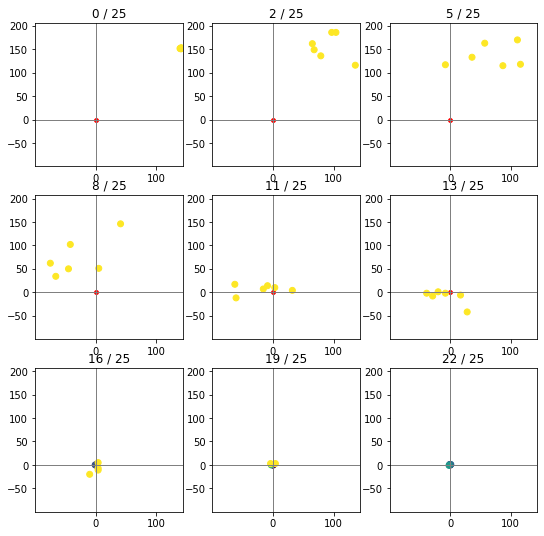

In [38]:
ana.plot_moving_cluster()

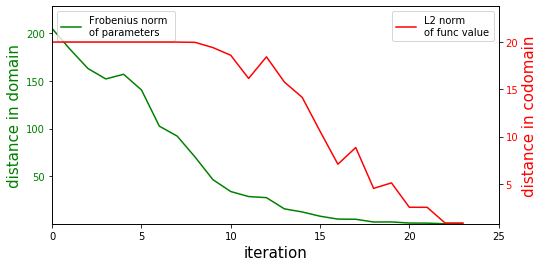

In [31]:
ana.plot_distance()

In [7]:
# 1 optimiser
inner_opt = line_search()
innerOptParas = {
    'x0': None,
    'alpha': 1,
    'beta': 0.1, 
    'max_iter': 100,
    'tol': 1e-2,              
    'verbose': False,
    'record': False
}
inner_opt.set_parameters(innerOptParas)

opt = cma_es()
optParas ={'x0': np.zeros((2,)),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': inner_opt, 
           'record': False, 
           'verbose': False}
opt.set_parameters(optParas)

# 2 objective function
obj = eggholder()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([-550,-550]),
             'edge': np.array([1100, 1100]),
             'step': 550,
             'size': 10,
             'sym': False}

data = do_multiple_exps(obj, opt, zoneParas)

/Users/huajian/Non-convex/library/objective_function.py:176: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/huajian/Non-convex/library/objective_function.py:176: RuntimeWarning:

invalid value encountered in double_scalars



cost: 330.7446182005433, prob: 0.0
complete: 2 / 4 
cost: 270.62116424046513, prob: 0.1
complete: 4 / 4 
avg probility of convergence:  0.025
avg cost:  312.83334313370943
avg evals per exp:  30259.8
total time: 29.350615978240967,  time per eval:6.0622128984331045e-05

